In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score
from scipy.stats import ttest_rel, t
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In concrete production processes, an important distinction that can be made is based on the
compressive strength of the concrete. Following the analysis done in Report 1, Data: Feature
extraction, and visualization, we have acquired a dataset containing 1030 instances of mixtures
with their respective ingredients along with an output value that indicates the compressive
strength of each mixture.More specifically, the dataset contains eight attributes, namely cement,
blast furnace slag, coarse and fine aggregates, fly ash, water, superplasticizer and age, which are
regarded as mixture ingredients and one output value, concrete’s compressive strength. Since
both attributes’ and output’s values are continuous, predicting concrete’s compressive strength
can easily be treated as a regression problem

#---------- REGRESSION, PART A ----------#

Assuming y to be the compressive strength value of concrete, we can create a function f for
linear regression, such as: y = f(attributes), indicating that the output value is related to the
input values of the attributes. This regression model will help us understand how aging and
different mixture ingredients influence the resulting strength, providing a quantitative way to
predict compressive strength for new concrete mixes.

In [16]:
# Organize the excel file in a dataframe
df = pd.read_excel("Concrete_Data.xls")

# Seperate the target variable (Concrete compressive strength) from the rest "predicting" attributes
X = df.drop(columns=['Concrete compressive strength(MPa, megapascals) '], axis=1)
# Target variable
y= df['Concrete compressive strength(MPa, megapascals) '].values

# Split data in training and test tests
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

# Implement linear regression fitting the training data
linreg = LinearRegression() 
linreg.fit(X_train_std, y_train) 

# Prediction values from the test data
y_pred = linreg.predict(X_test_std)

# Square Root of Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("\nRMSE :", rmse, "MPa")

w = linreg.coef_
w0 = linreg.intercept_

print("\nOptimal Coefficients (w*): \n")
for name, value in zip(X.columns, w):
    print(f"{name:25s} : {value:.4f}")
print("\nIntercept (w0):", w0)
print("\nMatrix equation: ŷ = Xw + w0")

equation = "ŷ = {:.3f}".format(w0)
for coef, name in zip(w, X.columns):
    equation += " + ({:.3f} × {})".format(coef, name)

print("\nLearned linear regression equation:\n \n", equation)



RMSE : 9.796707832398447 MPa

Optimal Coefficients (w*): 

Cement (component 1)(kg in a m^3 mixture) : 12.7865
Blast Furnace Slag (component 2)(kg in a m^3 mixture) : 9.4329
Fly Ash (component 3)(kg in a m^3 mixture) : 5.2556
Water  (component 4)(kg in a m^3 mixture) : -2.8921
Superplasticizer (component 5)(kg in a m^3 mixture) : 1.8411
Coarse Aggregate  (component 6)(kg in a m^3 mixture) : 1.4003
Fine Aggregate (component 7)(kg in a m^3 mixture) : 1.9474
Age (day)                 : 7.0378

Intercept (w0): 35.857718068042345

Matrix equation: ŷ = Xw + w0

Learned linear regression equation:
 
 ŷ = 35.858 + (12.787 × Cement (component 1)(kg in a m^3 mixture)) + (9.433 × Blast Furnace Slag (component 2)(kg in a m^3 mixture)) + (5.256 × Fly Ash (component 3)(kg in a m^3 mixture)) + (-2.892 × Water  (component 4)(kg in a m^3 mixture)) + (1.841 × Superplasticizer (component 5)(kg in a m^3 mixture)) + (1.400 × Coarse Aggregate  (component 6)(kg in a m^3 mixture)) + (1.947 × Fine Aggregate (

#--- REGULARIZATION PARAMETER λ AND 10-FOLD CROSS VALIDATION ---#

we introduce a regularization parameter λ and estimate the generalization error for different values of λ. Specifically a reasonable range of values of λ is chosen and  K = 10 fold cross-validation is used to estimate the generalization error. 

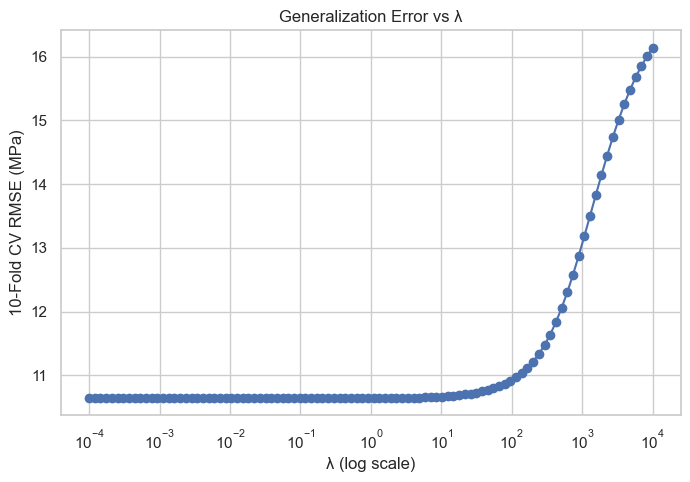

Optimal λ: 1.59228

RMSE for optimal λ (1.59228): 10.648 MPa

Test RMSE at optimal λ (1.59228): 9.797 MPa

Optimal Coefficients (w*):

Cement (component 1)(kg in a m^3 mixture) : 12.4329
Blast Furnace Slag (component 2)(kg in a m^3 mixture) : 9.0910
Fly Ash (component 3)(kg in a m^3 mixture) : 4.9530
Water  (component 4)(kg in a m^3 mixture) : -3.1199
Superplasticizer (component 5)(kg in a m^3 mixture) : 1.8444
Coarse Aggregate  (component 6)(kg in a m^3 mixture) : 1.1645
Fine Aggregate (component 7)(kg in a m^3 mixture) : 1.6431
Age (day)                 : 7.0079

Intercept (w0): 35.8577


In [17]:
# λ values range
lambdas = np.logspace(-4, 4, 100)

# 10-Fold Cross Validation 
tenfold = KFold(n_splits=10, shuffle=True, random_state=42)

mse_scores = []

# Pipeline creation to include scaling within each fold in order to avoid data leakage 
for l in lambdas:
    ridge_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=l))
    ])
    
    # Cross-validation returns negative MSE 
    neg_mse = cross_val_score(ridge_pipeline, X_train, y_train, cv=tenfold, scoring='neg_mean_squared_error')
    mse_scores.append(-neg_mse.mean())

rmse_scores = np.sqrt(mse_scores)

# Plot generalization error vs λ
plt.figure(figsize=(8,5))
plt.semilogx(lambdas, rmse_scores, marker='o')
plt.xlabel("λ (log scale)")
plt.ylabel("10-Fold CV RMSE (MPa)")
plt.title("Generalization Error vs λ")
plt.grid(True)
plt.show()

optimal_lambda = lambdas[np.argmin(mse_scores)]
print(f"Optimal λ: {optimal_lambda:.5f}")

# Train final model on standardized full data 
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=optimal_lambda))
])

neg_mse_opt = cross_val_score(final_pipeline, X_train, y_train, cv=tenfold, scoring='neg_mean_squared_error')
rmse_opt = np.sqrt(-neg_mse_opt.mean())
print(f"\nRMSE for optimal λ ({optimal_lambda:.5f}): {rmse_opt:.3f} MPa")

final_pipeline.fit(X_train, y_train)

y_test_pred = final_pipeline.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"\nTest RMSE at optimal λ ({optimal_lambda:.5f}): {rmse_test:.3f} MPa")

ridge_final = final_pipeline.named_steps['ridge']
w = ridge_final.coef_
w0 = ridge_final.intercept_

print("\nOptimal Coefficients (w*):\n")
for name, value in zip(X.columns, w):
    print(f"{name:25s} : {value:.4f}")

print(f"\nIntercept (w0): {w0:.4f}")

The optimal value of λ, corresponding to the minimum RMSE, was found to be
equal to 1.59228. At this optimal λ value, the RMSE is equal to 10.648.

# REGRESSION, PART B 

#--- TWO-LEVEL CROSS VALIDATION ---#

In this section the three models: the regularized linear regression model from the previous section, an artificial neural network (ANN) and a baseline. The research questions are:  Is one model better than the other? Is either model better than a trivial baseline? 

Comparing and evaluating a variety of regression models is essential for identifying the
optimal approach for a given predictive task. A systematic comparison not only helps improve
predictive accuracy but also ensures that the selected model achieves an appropriate balance
between complexity and generalization, mitigating the risks of overfitting and underfitting. The
objective of this experiment is to compare the performance of three machine learning models: a
baseline model, the Ridge Regression model developed in the previous section, and an Artificial
Neural Network (ANN), using the Concrete Compressive Strength Dataset.

A nested (two-level) 10 fold cross-validation procedure with K1 = K2 = 10 was implemented
in order to evaluate and compare the performance of the three models. This
approach allows an unbiased estimation of generalization performance while it simultaneously
enables hyperparameters tuning. Specifically, the regularization strength λ was optimized for
the Ridge Regression model, whereas the number of hidden units h was tuned for the ANN
model

Fold 1: λ*=1.5923, ANN Architecture=(20, 20), Ridge MSE=101.230, ANN MSE=38.155, Baseline MSE=268.475
Fold 2: λ*=1.5923, ANN Architecture=(10,), Ridge MSE=86.272, ANN MSE=53.907, Baseline MSE=247.717
Fold 3: λ*=0.9112, ANN Architecture=(20,), Ridge MSE=135.497, ANN MSE=72.584, Baseline MSE=299.112
Fold 4: λ*=1.0975, ANN Architecture=(20, 20), Ridge MSE=133.517, ANN MSE=59.139, Baseline MSE=371.855
Fold 5: λ*=1.9179, ANN Architecture=(10,), Ridge MSE=142.460, ANN MSE=66.012, Baseline MSE=263.155
Fold 6: λ*=1.5923, ANN Architecture=(20, 20), Ridge MSE=108.855, ANN MSE=65.365, Baseline MSE=304.371
Fold 7: λ*=2.3101, ANN Architecture=(20, 20), Ridge MSE=90.134, ANN MSE=47.572, Baseline MSE=302.581
Fold 8: λ*=0.5214, ANN Architecture=(10,), Ridge MSE=89.361, ANN MSE=113.084, Baseline MSE=261.799
Fold 9: λ*=0.2057, ANN Architecture=(20, 20), Ridge MSE=105.171, ANN MSE=48.718, Baseline MSE=244.908
Fold 10: λ*=0.0001, ANN Architecture=(20,), Ridge MSE=105.701, ANN MSE=56.305, Baseline MSE=227.

,Fold,ANN Architecture,ANN Test MSE,λ*,Ridge Test MSE,Baseline MSE
0,1,"(20, 20)",38.154709,1.592283,101.230207,268.475053
1,2,"(10,)",53.906821,1.592283,86.271716,247.717454
2,3,"(20,)",72.583801,0.911163,135.497315,299.112382
3,4,"(20, 20)",59.138512,1.097499,133.516787,371.855304
4,5,"(10,)",66.012346,1.917910,142.459636,263.154527
5,6,"(20, 20)",65.365268,1.592283,108.854517,304.370672
6,7,"(20, 20)",47.572146,2.310130,90.133779,302.581038
7,8,"(10,)",113.083712,0.521401,89.361050,261.798622
8,9,"(20, 20)",48.717861,0.205651,105.171006,244.908005
9,10,"(20,)",56.304686,0.000100,105.700572,227.350799



Average Test MSEs (Outer CV):
Ridge Test MSE    109.819659
ANN Test MSE       62.083986
Baseline MSE      279.132386
dtype: float64

Final Evaluation on Held-out Test Set:
Ridge RMSE: 9.797
ANN RMSE:   7.250
Baseline:   16.054


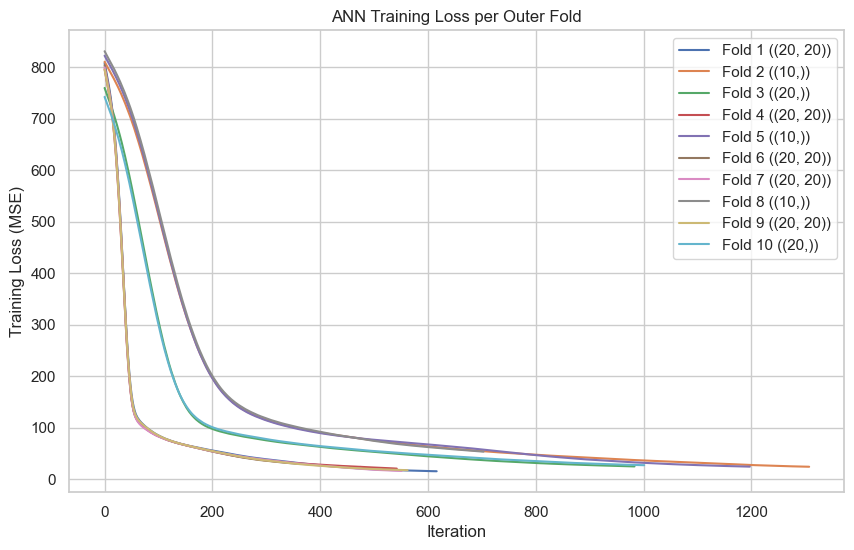

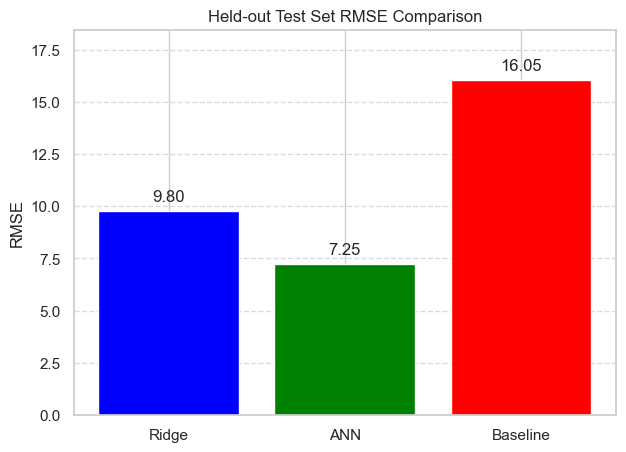

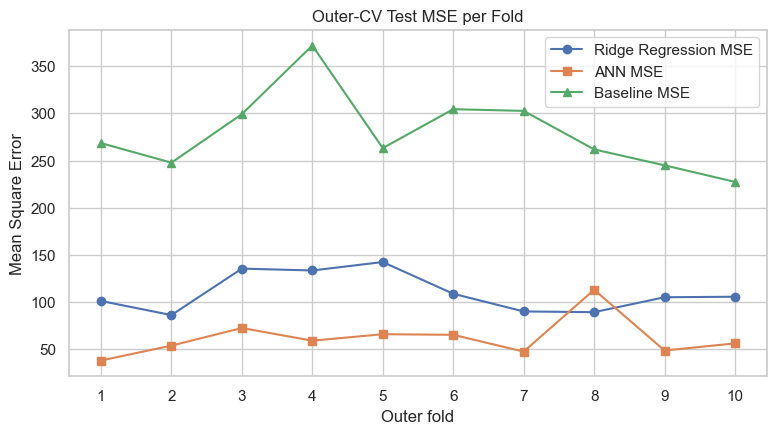

In [18]:
# Hyperparameters
lambdas_partb = np.logspace(-4, 4, 100)    
h_values = [1, 2, 5, 10, 20]              

K1 = K2 = 10
outer_cv = KFold(n_splits=K1, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=K2, shuffle=True, random_state=42)

# Pipelines
ridge_pipeline_partb = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())                    
])

mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        max_iter=2000,
        early_stopping=True,
        random_state=42
    ))
])

ridge_param_grid = {"ridge__alpha": lambdas_partb}
ann_param_grid = {
    "mlp__hidden_layer_sizes": [
        (h,) for h in h_values      # single-layer networks
    ] + [
        (h, h) for h in h_values    # two-layer networks with same units
    ] 
}

# Outer CV loop
results = []
ann_loss_curves = []

for fold_number, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    # Baseline
    baseline_pred = np.full_like(y_te, y_tr.mean(), dtype=float)
    baseline_mse = mean_squared_error(y_te, baseline_pred)

    # Ridge 
    ridge_gs = GridSearchCV(
        estimator=ridge_pipeline_partb,
        param_grid=ridge_param_grid,
        scoring="neg_mean_squared_error",
        cv=inner_cv,
        n_jobs=-1,
        refit=True
    )
    ridge_gs.fit(X_tr, y_tr)
    best_lambda = ridge_gs.best_params_["ridge__alpha"]
    ridge_test_mse = mean_squared_error(y_te, ridge_gs.best_estimator_.predict(X_te))

    # ANN
    ann_gs = GridSearchCV(
        estimator=mlp_pipeline,
        param_grid=ann_param_grid,
        scoring="neg_mean_squared_error",
        cv=inner_cv,
        n_jobs=-1,
        refit=True
    )
    ann_gs.fit(X_tr, y_tr)
    best_arch = ann_gs.best_params_["mlp__hidden_layer_sizes"] 
    ann_test_mse = mean_squared_error(y_te, ann_gs.best_estimator_.predict(X_te))
    best_ann = ann_gs.best_estimator_.named_steps["mlp"]
    ann_loss_curves.append(best_ann.loss_curve_)

    results.append({
        "Fold": fold_number,
        "ANN Architecture": best_arch,
        "ANN Test MSE": ann_test_mse,
        "λ*": best_lambda,
        "Ridge Test MSE": ridge_test_mse,
        "Baseline MSE": baseline_mse
    })

    print(f"Fold {fold_number}: λ*={best_lambda:.4f}, ANN Architecture={best_arch}, "
          f"Ridge MSE={ridge_test_mse:.3f}, ANN MSE={ann_test_mse:.3f}, "
          f"Baseline MSE={baseline_mse:.3f}")

results_df = pd.DataFrame(results).sort_values("Fold")
display(results_df)

print("\nAverage Test MSEs (Outer CV):")
print(results_df[["Ridge Test MSE", "ANN Test MSE", "Baseline MSE"]].mean())

# Held-out test set evaluation
baseline_rmse = np.sqrt(mean_squared_error(y_test, np.full_like(y_test, y_train.mean(), dtype=float)))

ridge_gs_final = GridSearchCV(
    estimator=ridge_pipeline_partb,
    param_grid=ridge_param_grid,
    scoring="neg_mean_squared_error",
    cv=inner_cv,
    n_jobs=-1,
    refit=True
).fit(X_train, y_train)
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, ridge_gs_final.best_estimator_.predict(X_test)))

ann_gs_final = GridSearchCV(
    estimator=mlp_pipeline,
    param_grid=ann_param_grid,
    scoring="neg_mean_squared_error",
    cv=inner_cv,
    n_jobs=-1,
    refit=True
).fit(X_train, y_train)
ann_test_rmse = np.sqrt(mean_squared_error(y_test, ann_gs_final.best_estimator_.predict(X_test)))

print("\nFinal Evaluation on Held-out Test Set:")
print(f"Ridge RMSE: {ridge_test_rmse:.3f}")
print(f"ANN RMSE:   {ann_test_rmse:.3f}")
print(f"Baseline:   {baseline_rmse:.3f}")

# Plot ANN Loss Curves
plt.figure(figsize=(10,6))
for i, loss_curve in enumerate(ann_loss_curves):
    plt.plot(loss_curve, label=f'Fold {i+1} ({results[i]["ANN Architecture"]})')
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('ANN Training Loss per Outer Fold')
plt.legend()
plt.grid(True)
plt.show()

# Bar plot of held-out test RMSE
models = ['Ridge', 'ANN', 'Baseline']
rmse_values = [ridge_test_rmse, ann_test_rmse, baseline_rmse]

plt.figure(figsize=(7,5))
bars = plt.bar(models, rmse_values, color=['blue','green','red'])
plt.ylabel('RMSE')
plt.title('Held-out Test Set RMSE Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(rmse_values)*1.15)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, f'{height:.2f}',
             ha='center', va='bottom')
plt.show()

# Outer-fold error curves
plt.figure(figsize=(9,4.5))
plt.plot(results_df["Fold"], results_df["Ridge Test MSE"], marker="o", label="Ridge Regression MSE")
plt.plot(results_df["Fold"], results_df["ANN Test MSE"], marker="s", label="ANN MSE")
plt.plot(results_df["Fold"], results_df["Baseline MSE"], marker="^", label="Baseline MSE")
plt.xlabel("Outer fold")
plt.ylabel("Mean Square Error")
plt.title("Outer-CV Test MSE per Fold")
plt.xticks(results_df["Fold"])
plt.grid(True)
plt.legend()
plt.show()

#--- STATISTICAL EVALUATION ---#

Pairwise statistical evaluation for the baseline model, regularized linear regression and artificial neural networks
(Paired t-test method)


Pairwise Model Comparison (Paired t-test)

       Comparison   Mean ΔMSE  95% CI Lower  95% CI Upper      p-value  Significant (α=0.05)
     ANN vs Ridge  -47.735672    -68.339345    -27.132000 5.339903e-04                  True
  ANN vs Baseline -217.048400   -250.345224   -183.751575 1.308301e-07                  True
Ridge vs Baseline -169.312727   -196.427483   -142.197972 1.898471e-07                  True


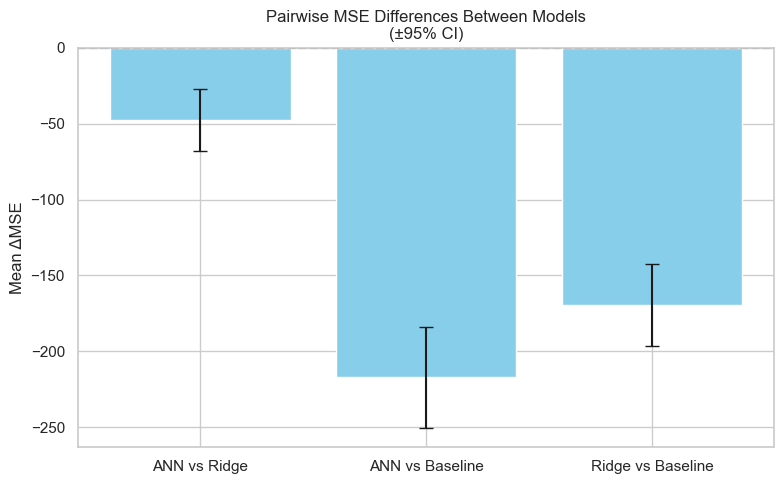

In [19]:
# Compute Pairwise differences
ridge_mse = results_df['Ridge Test MSE'].values
ann_mse = results_df['ANN Test MSE'].values
baseline_mse = results_df['Baseline MSE'].values

z_ann_ridge = ann_mse - ridge_mse
z_ann_base = ann_mse - baseline_mse
z_ridge_base = ridge_mse - baseline_mse

# Paired t-tests
t_ann_ridge = ttest_rel(ann_mse, ridge_mse)
t_ann_base = ttest_rel(ann_mse, baseline_mse)
t_ridge_base = ttest_rel(ridge_mse, baseline_mse)

# Confidence Intervals
def confidence_interval(z, alpha=0.05):
    n = len(z)
    z_bar = np.mean(z)
    s = np.std(z, ddof=1)
    t_crit = t.ppf(1 - alpha/2, n - 1)
    margin = t_crit * s / np.sqrt(n)
    return z_bar - margin, z_bar + margin

ci_ann_ridge = confidence_interval(z_ann_ridge)
ci_ann_base = confidence_interval(z_ann_base)
ci_ridge_base = confidence_interval(z_ridge_base)

# Summary Table
summary = pd.DataFrame({
    "Comparison": ["ANN vs Ridge", "ANN vs Baseline", "Ridge vs Baseline"],
    "Mean ΔMSE": [np.mean(z_ann_ridge), np.mean(z_ann_base), np.mean(z_ridge_base)],
    "95% CI Lower": [ci_ann_ridge[0], ci_ann_base[0], ci_ridge_base[0]],
    "95% CI Upper": [ci_ann_ridge[1], ci_ann_base[1], ci_ridge_base[1]],
    "p-value": [t_ann_ridge.pvalue, t_ann_base.pvalue, t_ridge_base.pvalue]
})

summary["Significant (α=0.05)"] = summary["p-value"] < 0.05

print("\nPairwise Model Comparison (Paired t-test)\n")
print(summary.to_string(index=False))

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Data for plotting
comparisons = summary["Comparison"]
mean_delta = summary["Mean ΔMSE"]
ci_lower = summary["95% CI Lower"]
ci_upper = summary["95% CI Upper"]

# Compute error bars
error_lower = mean_delta - ci_lower
error_upper = ci_upper - mean_delta
error = [error_lower, error_upper]

# Bar plot with error bars
plt.bar(comparisons, mean_delta, yerr=error, capsize=5, color='skyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel("Mean ΔMSE")
plt.title("Pairwise MSE Differences Between Models\n(±95% CI)")
plt.tight_layout()
plt.show()

The interpretation of the table reveals some consistent trends across all 10 folds: the ANN
almost consistently outperforms Ridge Regression, while both Ridge Regression and the ANN
outperform the baseline model by a significant margin

# CLASSIFICATION

#--- TWO-LEVEL CROSS-VALIDATION ---#

Predicting concrete’s compressive strength is considered to be a regression problem, since
the target variable is continuous. However, there are occasions where predicting the strength
category of the concrete is more relevant than estimating its precise numerical value. Thus,
in such cases, the regression problem can be converted into a multi-class classification problem
by applying threshold-based discretization to the compressive strength values


In [20]:
# Divide target variable in classes with threshold values
def categorize_strength(value):
    if value < 25.01:
        return 0  # low
    elif value < 55.02:
        return 1  # medium
    else:
        return 2  # high

y_classes = np.array([categorize_strength(val) for val in y])

num_low = np.sum(y_classes == 0)
num_medium = np.sum(y_classes == 1)
num_high = np.sum(y_classes == 2)

print(f"Class distribution:\n Low: {num_low}\n Medium: {num_medium}\n High: {num_high}")

Class distribution:
 Low: 295
 Medium: 588
 High: 147


A nested (two-level) 10 fold cross-validation procedure was applied to all models in order
to enable both performance evaluation and hyperparameter optimization via grid search. The
models that were compared are the following: a logistic regression classifier, an artificial neural
network (ANN), and a baseline estimator that always predicts the majority class of the training
data

In [21]:
# Cross-validation setup
K1 = K2 = 10
outer_cv = StratifiedKFold(n_splits=K1, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=K2, shuffle=True, random_state=42)

# Model Pipelines
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=2000,
        multi_class="multinomial",
        solver="lbfgs",
        random_state=42
    ))
])

mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        max_iter=2000,
        early_stopping=True,  
        random_state=42
    ))
])

# Logistic regression parameter range
logreg_params = {'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Hidden layers
h1 = [8, 16, 25, 32]
hidden_layer_sizes = [(h,) for h in h1]

hidden_layer_sizes += [(h1_, h2_) for h1_ in h1 for h2_ in h1 if h2_ < h1_]

hidden_layer_sizes += [(h1_, h2_, h3_) for h1_ in h1 for h2_ in h1 for h3_ in h1 if h3_ < h2_ < h1_]
print(f"Total number of configurations: {len(hidden_layer_sizes)}")

mlp_params = {
    'mlp__hidden_layer_sizes': hidden_layer_sizes,
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001, 0.01],  
    'mlp__learning_rate_init': [0.001, 0.01],
    'mlp__learning_rate': ['constant', 'adaptive']
}

Total number of configurations: 14


In [22]:
results = []
predictions = []

for fold_number, (train_idx, test_idx) in enumerate(outer_cv.split(X, y_classes), start=1):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y_classes[train_idx], y_classes[test_idx]

    # Baseline
    baseline = DummyClassifier(strategy='most_frequent')
    baseline.fit(X_tr, y_tr)
    y_pred_base = baseline.predict(X_te)
    err_base = 1 - accuracy_score(y_te, y_pred_base)

    # Logistic Regression
    grid_logreg = GridSearchCV(
        estimator = logreg_pipeline,
        param_grid = logreg_params, 
        cv=inner_cv, 
        n_jobs=-1)
    grid_logreg.fit(X_tr, y_tr)
    y_pred_logreg = grid_logreg.best_estimator_.predict(X_te)
    err_logreg = 1 - accuracy_score(y_te, y_pred_logreg)

    best_logreg_params = grid_logreg.best_params_

    # MLP
    grid_mlp = GridSearchCV(
        estimator = mlp_pipeline,
        param_grid = mlp_params,
        cv=inner_cv, 
        n_jobs=-1)
    grid_mlp.fit(X_tr, y_tr)
    y_pred_mlp = grid_mlp.best_estimator_.predict(X_te)
    err_mlp = 1 - accuracy_score(y_te, y_pred_mlp)

    best_mlp_params = grid_mlp.best_params_
    
    results.append({
        'Fold': fold_number,
        'h*': grid_mlp.best_params_['mlp__hidden_layer_sizes'],
        'λ*': grid_mlp.best_params_['mlp__alpha'],
        'MLP Error': err_mlp,
        # 'MLP Params': grid_mlp.best_params_,
        'C*': grid_logreg.best_params_['logreg__C'],
        'LogReg Error': err_logreg,
        # 'LogReg Params': grid_logreg.best_params_,
        'Baseline Error': err_base,
    })

    predictions.append({
        'y_true': y_te,
        "y_pred_base": y_pred_base,
        'y_pred_logreg': y_pred_logreg,
        'y_pred_mlp': y_pred_mlp
    })

    print(f"Fold {fold_number:2d}: C*={grid_logreg.best_params_['logreg__C']:<6},h*={grid_mlp.best_params_['mlp__hidden_layer_sizes']}, λ*={grid_mlp.best_params_['mlp__alpha']}", 
          f"Error for Logistic Regression={err_logreg:.3f}, Error for MLP={err_mlp:.3f}, Error for Baseline={err_base:.3f}")

# Results table
results_df = pd.DataFrame(results).sort_values("Fold")
display(results_df)

Fold  1: C*=100   ,h*=(32, 25, 16), λ*=0.01 Error for Logistic Regression=0.233, Error for MLP=0.165, Error for Baseline=0.427
Fold  2: C*=1     ,h*=(32, 16), λ*=0.001 Error for Logistic Regression=0.223, Error for MLP=0.165, Error for Baseline=0.427
Fold  3: C*=10    ,h*=(32, 25, 16), λ*=0.0001 Error for Logistic Regression=0.223, Error for MLP=0.146, Error for Baseline=0.427
Fold  4: C*=100   ,h*=(32, 25), λ*=0.0001 Error for Logistic Regression=0.136, Error for MLP=0.146, Error for Baseline=0.427
Fold  5: C*=10    ,h*=(32, 25, 16), λ*=0.01 Error for Logistic Regression=0.272, Error for MLP=0.165, Error for Baseline=0.427
Fold  6: C*=10    ,h*=(32, 16, 8), λ*=0.0001 Error for Logistic Regression=0.175, Error for MLP=0.165, Error for Baseline=0.437
Fold  7: C*=100   ,h*=(32, 25), λ*=0.001 Error for Logistic Regression=0.184, Error for MLP=0.107, Error for Baseline=0.437
Fold  8: C*=1     ,h*=(32, 16), λ*=0.01 Error for Logistic Regression=0.194, Error for MLP=0.194, Error for Baseline

,Fold,h*,λ*,MLP Error,C*,LogReg Error,Baseline Error
0,1,"(32, 25, 16)",0.0100,0.165049,100,0.233010,0.427184
1,2,"(32, 16)",0.0010,0.165049,1,0.223301,0.427184
2,3,"(32, 25, 16)",0.0001,0.145631,10,0.223301,0.427184
3,4,"(32, 25)",0.0001,0.145631,100,0.135922,0.427184
4,5,"(32, 25, 16)",0.0100,0.165049,10,0.271845,0.427184
5,6,"(32, 16, 8)",0.0001,0.165049,10,0.174757,0.436893
6,7,"(32, 25)",0.0010,0.106796,100,0.184466,0.436893
7,8,"(32, 16)",0.0100,0.194175,1,0.194175,0.427184
8,9,"(32, 25, 8)",0.0010,0.155340,100,0.184466,0.427184
9,10,"(32, 25, 8)",0.0100,0.097087,100,0.135922,0.427184


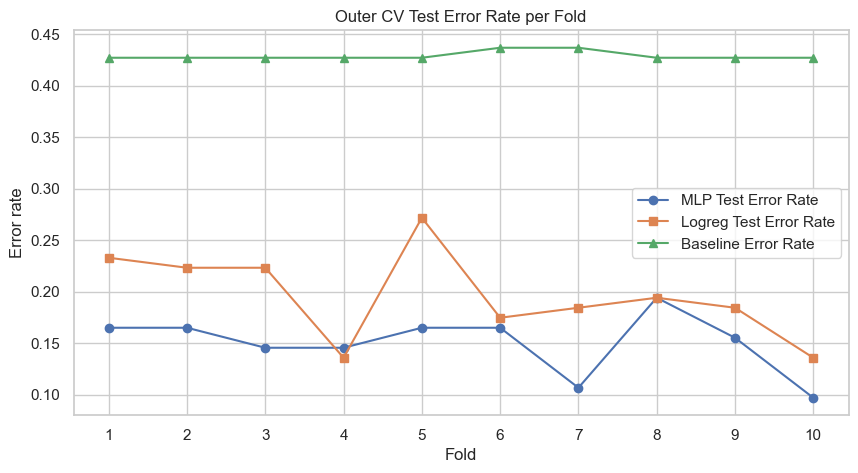

In [23]:
# Plot outer CV test Error rate per Fold for every model
folds = results_df['Fold'].values
mlp_error = results_df['MLP Error'].values
logreg_error = results_df['LogReg Error'].values
baseline_error = results_df['Baseline Error'].values

plt.figure(figsize=(10,5))
plt.plot(folds, mlp_error, marker='o', label='MLP Test Error Rate')
plt.plot(folds, logreg_error, marker='s', label='Logreg Test Error Rate')
plt.plot(folds, baseline_error, marker='^', label='Baseline Error Rate')
plt.xlabel('Fold')
plt.ylabel('Error rate')
plt.title('Outer CV Test Error Rate per Fold')
plt.xticks(folds)
plt.grid(True)
plt.legend()
plt.show()


In [24]:
# For Logistic Regression
logreg_params = results_df['C*']
most_common_logreg = logreg_params.mode()[0]
print("Most frequent LogReg C:", most_common_logreg)

# For MLP
mlp_params_df = results_df[['h*', 'λ*']]
most_common_mlp = mlp_params_df.value_counts().idxmax()
print("Most frequent MLP configuration:", most_common_mlp)

Most frequent LogReg C: 100
Most frequent MLP configuration: ((32, 25, 16), np.float64(0.01))


In [25]:
numeric_results = results_df[['Baseline Error', 'LogReg Error', 'MLP Error']].copy()

# Compute mean values +/- STD
summary = numeric_results.agg(['mean', 'std'])
summary_row = summary.apply(lambda x: f"{x['mean']:.3f} ± {x['std']:.3f}")
print(summary_row)

Baseline Error    0.429 ± 0.004
LogReg Error      0.196 ± 0.043
MLP Error         0.150 ± 0.029
dtype: object


#--- STATISTICAL EVALUATION ---#

Pairwise statistical evaluation for the baseline model, regularized linear regression and artificial neural networks
(McNemar's test)

In [26]:
# McNemar's test

y_true_all = np.concatenate([r['y_true'] for r in predictions])
y_pred_baseline = np.concatenate([r['y_pred_base'] for r in predictions])
y_pred_logreg = np.concatenate([r['y_pred_logreg'] for r in predictions])
y_pred_mlp = np.concatenate([r['y_pred_mlp'] for r in predictions])

def mcnemar_test(y_true, y_pred_model1, y_pred_model2):
    n12 = np.sum((y_pred_model1 == y_true) & (y_pred_model2 != y_true))
    n21 = np.sum((y_pred_model1 != y_true) & (y_pred_model2 == y_true))

    table = [[0, n12],
            [n21, 0]]

    result = mcnemar(table, exact=True)

    print(f"n12 = {n12}, n21 = {n21}")
    print(f"McNemar statistic = {result.statistic}, p-value = {result.pvalue}")

print("Baseline vs Logistic Regression:")
mcnemar_test(y_true_all, y_pred_baseline, y_pred_logreg)

print("\nBaseline vs MLP:")
mcnemar_test(y_true_all, y_pred_baseline, y_pred_mlp)

print("\nMLP vs Logistic Regression:")
mcnemar_test(y_true_all, y_pred_mlp, y_pred_logreg)


Baseline vs Logistic Regression:
n12 = 93, n21 = 333
McNemar statistic = 93.0, p-value = 9.08853656519026e-33

Baseline vs MLP:
n12 = 59, n21 = 346
McNemar statistic = 59.0, p-value = 1.706839739540317e-50

MLP vs Logistic Regression:
n12 = 90, n21 = 43
McNemar statistic = 43.0, p-value = 5.632966571164188e-05


McNemar’s test shows that both Logistic Regression and the MLP significantly outperform the baseline model
on the instances where their predictions differ. 

# FINAL LOGISTIC REGRESSION MODEL 

Train a final logistic regression model using a suitable λ value 

In [27]:
# Final logistic regression model

C_mode = most_common_logreg
final_logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("final_logreg", LogisticRegression(
        C = C_mode,
        max_iter=2000,
        multi_class="multinomial",
        solver="lbfgs",
        random_state=42
    ))
])

final_logreg_pipeline.fit(X, y_classes)

final_logreg = final_logreg_pipeline.named_steps["final_logreg"]
coef_df = pd.DataFrame(final_logreg.coef_, columns=X.columns, index=[f"class={c}" for c in final_logreg.classes_])
intercepts = pd.Series(final_logreg.intercept_, index=coef_df.index, name="intercept")
display(pd.concat([intercepts, coef_df], axis=1))

,intercept,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
class=0,-1.982639,-3.029283,-2.095803,-1.313150,0.444569,-0.338878,-0.474331,-0.561514,-6.210161
class=1,2.797445,0.048740,-0.129549,-0.247738,0.298543,0.249237,-0.073755,-0.052235,2.542202
class=2,-0.814806,2.980542,2.225353,1.560888,-0.743113,0.089641,0.548086,0.613750,3.667959


In [28]:
# Predictions
X_train, X_test, y_train, y_test = train_test_split(X, y_classes, test_size=0.2, random_state=42, stratify=y_classes)

y_pred_final_logreg = final_logreg_pipeline.predict(X_test)

# Accuracy and classification report
final_logreg_acc = accuracy_score(y_test, y_pred_final_logreg)
print("Accuracy:", final_logreg_acc)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_final_logreg))
print("\nClassification Report:\n", classification_report(y_test, y_pred_final_logreg))

Accuracy: 0.8495145631067961

Confusion Matrix:
 [[ 47  12   0]
 [  6 107   5]
 [  0   8  21]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84        59
           1       0.84      0.91      0.87       118
           2       0.81      0.72      0.76        29

    accuracy                           0.85       206
   macro avg       0.85      0.81      0.83       206
weighted avg       0.85      0.85      0.85       206

